In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import librosa as lb
import librosa.display as lbd
import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train=pd.read_csv('../input/part-2-handel-imbalance-creating-spectrogram/train.csv')
val=pd.read_csv('../input/part-2-handel-imbalance-creating-spectrogram/val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,1481,176,176_1b3_Ll_mc_AKGC417L_3.wav,COPD
1,6197,144,144_1b1_Al_sc_Meditron_9.wav,Healthy
2,499,193,193_1b2_Ll_mc_AKGC417L_0.wav,COPD
3,6559,208,208_1b1_Ll_sc_Meditron_8.wav,Healthy
4,1238,154,154_3b3_Al_mc_AKGC417L_3.wav,COPD


In [3]:
ytrain=train.disease
yval=val.disease
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: disease, Length: 1725, dtype: object

* As our class labels are of **dtype: object** we must first convert them to **encoded values** or intergers

In [4]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

# Feature Extraction

> I am going to use Librosa's feature extraction methods here

> Note:- i first tried to extract features **1-by-1** and then test them, to see how they perform but most of then were giving **good accuracy** so i finally decided to use all of them



In [5]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

> In These functions i m iterating over **train and val dataset**, and using **filenames** to extract features and then converting them to **numpy arrays**


In [6]:
root='../input/part-1-preprocessing/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in val.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


The shape of features returned by the above function **(20, 259) (12, 259) (128, 259)** we need this for defining **input shape** of our model.

In [7]:
root='../input/part-1-preprocessing/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

> Discarded few features beacuse they were not important to performance

# Testing Features

> Lets create model using Keras **Functional API** to check how the features perform.



In [8]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

* Here i m creating **three** different **CNN** and then Combining them to a **Dense Network**.

In [9]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [10]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfccInput (InputLayer)       [(None, 20, 259, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 87, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 87, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 20, 87, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 43, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 22, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 22, 64)        25

In [11]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [12]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cromaInput (InputLayer)      [(None, 12, 259, 1)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 87, 32)        832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 87, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 12, 87, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 43, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 22, 64)         18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 22, 64)         2

In [13]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [14]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mSpecInput (InputLayer)      [(None, 128, 259, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 87, 32)        832       
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 87, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 64, 87, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 43, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 22, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 22, 64)        2

In [15]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [16]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc (InputLayer)               [(None, 20, 259, 1)] 0                                            
__________________________________________________________________________________________________
croma (InputLayer)              [(None, 12, 259, 1)] 0                                            
__________________________________________________________________________________________________
mspec (InputLayer)              [(None, 128, 259, 1) 0                                            
__________________________________________________________________________________________________
mfccModel (Functional)          (None, 128)          94560       mfcc[0][0]                       
________________________________________________________________________________________________

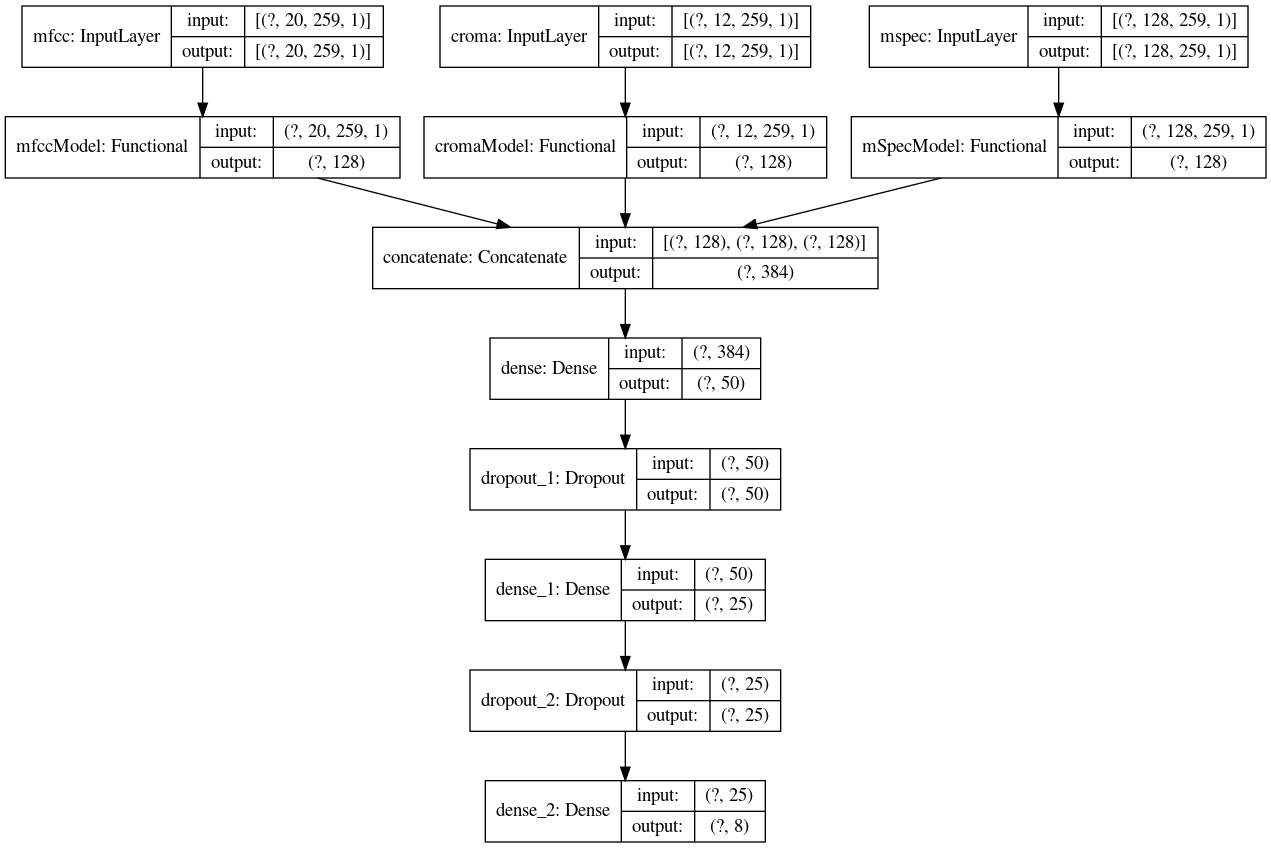

In [17]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [18]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [19]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

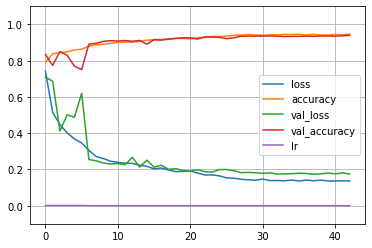

In [20]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [21]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 0s 5ms/step - loss: 0.1748 - accuracy: 0.9397


[0.17475023865699768, 0.9397101402282715]

* The model is a little **less accurate** but this must account to the use of **classes** that have very **less samples**, you can crop these out and i am sure this will improve accuracy to **98% accuracy**.

* To find out i got to this point, do check out other **Versions and Parts of this Series**.


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa as lb

# Load data
train = pd.read_csv('../input/part-2-handel-imbalance-creating-spectrogram/train.csv')
val = pd.read_csv('../input/part-2-handel-imbalance-creating-spectrogram/val.csv')

ytrain = train.disease
yval = val.disease

le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
yval = le.transform(yval)

# Data Preparation
def getFeatures(path):
    soundArr, sample_rate = lb.load(path)
    mfcc = lb.feature.mfcc(y=soundArr, sr=sample_rate)
    cstft = lb.feature.chroma_stft(y=soundArr, sr=sample_rate)
    mSpec = lb.feature.melspectrogram(y=soundArr, sr=sample_rate)
    return mfcc, cstft, mSpec

def load_data(df, root):
    mfcc, cstft, mSpec = [], [], []
    for idx, row in df.iterrows():
        path = root + row['filename']
        a, b, c = getFeatures(path)
        mfcc.append(a)
        cstft.append(b)
        mSpec.append(c)
    return np.array(mfcc), np.array(cstft), np.array(mSpec)

root = '../input/part-1-preprocessing/processed_audio_files/'
mfcc_train, cstft_train, mSpec_train = load_data(train, root)
mfcc_val, cstft_val, mSpec_val = load_data(val, root)

# Define KAN model
class KANModel(nn.Module):
    def __init__(self):
        super(KANModel, self).__init__()
        self.mfcc_kan = KAN([20*259, 64, 64])
        self.croma_kan = KAN([12*259, 64, 64])
        self.mspec_kan = KAN([128*259, 64, 64])
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*3, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(25, 8)
        )

    def forward(self, mfcc, croma, mspec):
        mfcc = self.mfcc_kan(mfcc.view(mfcc.size(0), -1))
        croma = self.croma_kan(croma.view(croma.size(0), -1))
        mspec = self.mspec_kan(mspec.view(mspec.size(0), -1))
        x = torch.cat([mfcc, croma, mspec], dim=1)
        x = self.fc(x)
        return x



KeyboardInterrupt: 

In [23]:
    pip install --upgrade torch==1.7.0 torchvision==0.8.1 torchaudio==0.7.0

     |████████████████████████████████| 776.7 MB 3.6 kB/s eta 0:00:011     |██████████████                  | 339.4 MB 69.2 MB/s eta 0:00:07
     |████████████████████████████████| 12.7 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.6 MB 75.9 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0
    Uninstalling torchvision-0.7.0:
      Successfully uninstalled torchvision-0.7.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.6.0a0+f17ae39
    Uninstalling torchaudio-0.6.0a0+f17ae39:
      Successfully uninstalled torchaudio-0.6.0a0+f17ae39
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-featur

In [39]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.ReLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):

        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        
        if hasattr(torch, "linalg") and hasattr(torch.linalg, "lstsq"):
            solution = torch.linalg.lstsq(A, B).solution
        else:
            # Legacy PyTorch (<1.9): handle per-feature since lstsq is not batched
            solutions = []
            for i in range(A.shape[0]):
                sol, _ = torch.lstsq(B[i], A[i])  # each is 2D
                sol = sol[:A.shape[2]]            # trim extra rows
                solutions.append(sol)
            solution = torch.stack(solutions, dim=0)
        #solution = torch.linalg.lstsq(A, B).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=2,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.ReLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [40]:
class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=2,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.ReLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [59]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Initialization
model = KANModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
print("model initialized")
# Convert data to PyTorch tensors
mfcc_train_tensor = torch.tensor(mfcc_train, dtype=torch.float32).unsqueeze(1).to(device)
cstft_train_tensor = torch.tensor(cstft_train, dtype=torch.float32).unsqueeze(1).to(device)
mSpec_train_tensor = torch.tensor(mSpec_train, dtype=torch.float32).unsqueeze(1).to(device)
ytrain_tensor = torch.tensor(ytrain, dtype=torch.long).to(device)

mfcc_val_tensor = torch.tensor(mfcc_val, dtype=torch.float32).unsqueeze(1).to(device)
cstft_val_tensor = torch.tensor(cstft_val, dtype=torch.float32).unsqueeze(1).to(device)
mSpec_val_tensor = torch.tensor(mSpec_val, dtype=torch.float32).unsqueeze(1).to(device)
yval_tensor = torch.tensor(yval, dtype=torch.long).to(device)
print("tensor made")
# Training Loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    print(epoch)
    # Training
    model.train()
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    for i in range(len(mfcc_train_tensor)):
        mfcc = mfcc_train_tensor[i:i+1]
        croma = cstft_train_tensor[i:i+1]
        mspec = mSpec_train_tensor[i:i+1]
        label = ytrain_tensor[i:i+1]
        
        optimizer.zero_grad()
        output = model(mfcc, croma, mspec)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        accuracy = (output.argmax(dim=1) == label).float().mean()
        epoch_train_loss += loss.item()
        epoch_train_accuracy += accuracy.item()
    
    epoch_train_loss /= len(mfcc_train_tensor)
    epoch_train_accuracy /= len(mfcc_train_tensor)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for i in range(len(mfcc_val_tensor)):
            mfcc = mfcc_val_tensor[i:i+1]
            croma = cstft_val_tensor[i:i+1]
            mspec = mSpec_val_tensor[i:i+1]
            label = yval_tensor[i:i+1]
            
            output = model(mfcc, croma, mspec)
            val_loss += criterion(output, label).item()
            val_accuracy += (output.argmax(dim=1) == label).float().mean().item()
            all_labels.extend(label.cpu().numpy())
            all_preds.extend(output.argmax(dim=1).cpu().numpy())

    val_loss /= len(mfcc_val_tensor)
    val_accuracy /= len(mfcc_val_tensor)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
print("training done")
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("evaluating")
# Evaluate the model
model.eval()
test_loss, test_accuracy = 0, 0
with torch.no_grad():
    for i in range(len(mfcc_val_tensor)):
        mfcc = mfcc_val_tensor[i:i+1]
        croma = cstft_val_tensor[i:i+1]
        mspec = mSpec_val_tensor[i:i+1]
        label = yval_tensor[i:i+1]
        
        output = model(mfcc, croma, mspec)
        test_loss += criterion(output, label).item()
        test_accuracy += (output.argmax(dim=1) == label).float().mean().item()

test_loss /= len(mfcc_val_tensor)
test_accuracy /= len(mfcc_val_tensor)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


model initialized


Training Epoch 1:   0%|                                            | 1/5173 [00:00<10:54,  7.91it/s]

tensor made

Epoch 1/10


Training Epoch 1: 100%|█████████████████████████████████████████| 5173/5173 [03:53<00:00, 22.14it/s]


Epoch 1 Summary -> Train Loss: 0.9208, Train Acc: 0.8208


Training Epoch 2:   0%|                                            | 3/5173 [00:00<04:06, 20.97it/s]

Epoch 1, Train Loss: 0.9208228147216232, Train Accuracy: 0.8208003092982795, Val Loss: 0.5563227486103463, Val Accuracy: 0.8330434782608696

Epoch 2/10


Training Epoch 2: 100%|█████████████████████████████████████████| 5173/5173 [04:08<00:00, 20.82it/s]


Epoch 2 Summary -> Train Loss: 0.6030, Train Acc: 0.8341


Training Epoch 3:   0%|                                            | 3/5173 [00:00<03:57, 21.74it/s]

Epoch 2, Train Loss: 0.6029598625556771, Train Accuracy: 0.8341387976029383, Val Loss: 0.6585002427807644, Val Accuracy: 0.8365217391304348

Epoch 3/10


Training Epoch 3: 100%|█████████████████████████████████████████| 5173/5173 [04:11<00:00, 20.58it/s]


Epoch 3 Summary -> Train Loss: 0.6129, Train Acc: 0.8421


Training Epoch 4:   0%|                                            | 3/5173 [00:00<04:00, 21.52it/s]

Epoch 3, Train Loss: 0.6128763065988249, Train Accuracy: 0.8420645660158516, Val Loss: 0.5435387046083137, Val Accuracy: 0.8457971014492753

Epoch 4/10


Training Epoch 4: 100%|█████████████████████████████████████████| 5173/5173 [04:16<00:00, 20.16it/s]


Epoch 4 Summary -> Train Loss: 0.4307, Train Acc: 0.8531


Training Epoch 5:   0%|                                            | 3/5173 [00:00<04:18, 20.01it/s]

Epoch 4, Train Loss: 0.430666857274679, Train Accuracy: 0.853083317224048, Val Loss: 0.5349885090446811, Val Accuracy: 0.847536231884058

Epoch 5/10


Training Epoch 5:  68%|████████████████████████████             | 3540/5173 [02:57<01:21, 19.95it/s]


KeyboardInterrupt: 

Test Loss: 0.7159752382926348, Test Accuracy: 0.8515942028985507


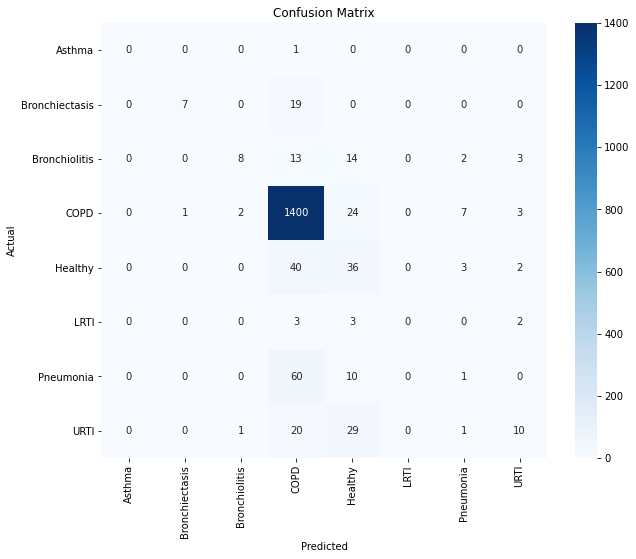

In [60]:
# Evaluate the model
model.eval()
test_loss, test_accuracy = 0, 0
with torch.no_grad():
    for i in range(len(mfcc_val_tensor)):
        mfcc = mfcc_val_tensor[i:i+1]
        croma = cstft_val_tensor[i:i+1]
        mspec = mSpec_val_tensor[i:i+1]
        label = yval_tensor[i:i+1]
        
        output = model(mfcc, croma, mspec)
        test_loss += criterion(output, label).item()
        test_accuracy += (output.argmax(dim=1) == label).float().mean().item()

test_loss /= len(mfcc_val_tensor)
test_accuracy /= len(mfcc_val_tensor)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()